In [113]:
#Importing Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Resizing
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [114]:
#Image count

In [115]:
import os

count = 0
dirs = os.listdir('Images/')
print(f'Total Categories: {len(dirs)}\n')

for dir in dirs:
    files = list(os.listdir(os.path.join('Images', dir)))
    print(f"{dir} Folder has {len(files)} Images")
    count += len(files)

print(f'\nTotal Images: {count}')

Total Categories: 20

Bougainvillea Folder has 612 Images
Bush Clock Vine Folder has 138 Images
Butterfly Pea Folder has 241 Images
Cape Jasmine Folder has 160 Images
Champak Folder has 228 Images
Dahlia Folder has 1373 Images
Daisy Folder has 958 Images
Dandelion Folder has 1052 Images
Datura Folder has 231 Images
Four O' Clock Flower Folder has 210 Images
Hibiscus Folder has 1759 Images
Jungle geranium Folder has 906 Images
Marigold Folder has 1921 Images
Peacock Flower Folder has 617 Images
Periwinkle Folder has 837 Images
Potato vine Folder has 181 Images
Rose Folder has 1959 Images
Sunflower Folder has 1685 Images
Touch Me Not Folder has 201 Images
tulip Folder has 984 Images

Total Images: 16253


In [116]:
base_dir = 'Images/'
img_size = 180
batch = 32

In [117]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 16253 files belonging to 20 classes.
Using 13003 files for training.
Found 16253 files belonging to 20 classes.
Using 3250 files for validation.


In [118]:
flower_names = train_ds.class_names
flower_names

['Bougainvillea',
 'Bush Clock Vine',
 'Butterfly Pea',
 'Cape Jasmine',
 'Champak',
 'Dahlia',
 'Daisy',
 'Dandelion',
 'Datura',
 "Four O' Clock Flower",
 'Hibiscus',
 'Jungle geranium',
 'Marigold',
 'Peacock Flower',
 'Periwinkle',
 'Potato vine',
 'Rose',
 'Sunflower',
 'Touch Me Not',
 'tulip']

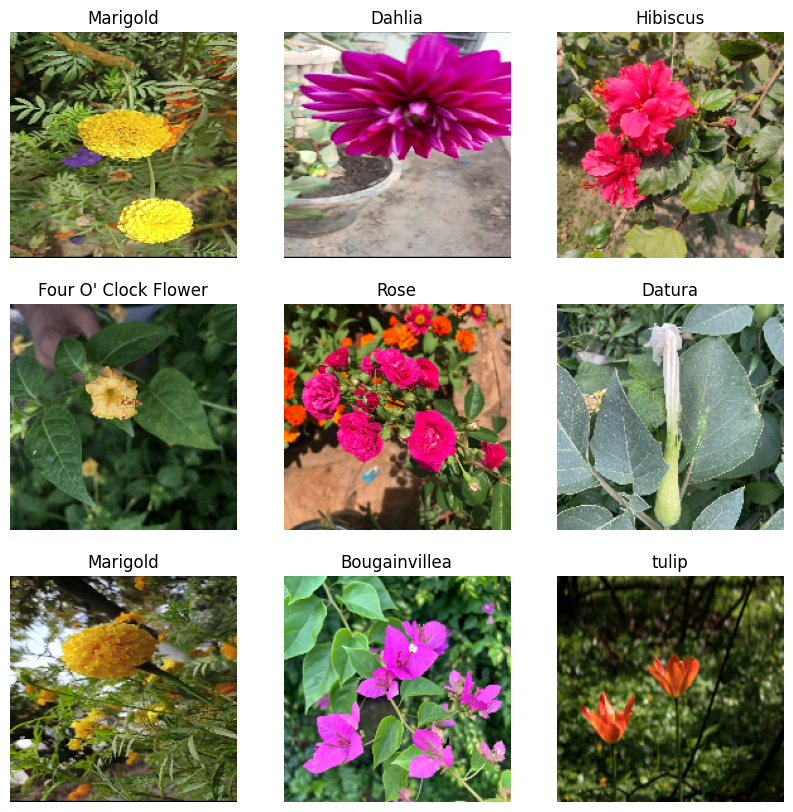

In [119]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [120]:
AUTOTUNE = tf.data.AUTOTUNE

In [121]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [122]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [123]:
#Data Augmentation

In [124]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),  # Flip horizontally
    layers.RandomRotation(0.1),  # Rotate up to 10%
    layers.RandomZoom(0.1),  # Zoom in/out up to 10%
    layers.RandomContrast(0.1),  # Add random contrast
    layers.RandomBrightness(0.1),  # Random brightness change
    layers.Resizing(180, 180, interpolation="bilinear")  # Resize the image
])

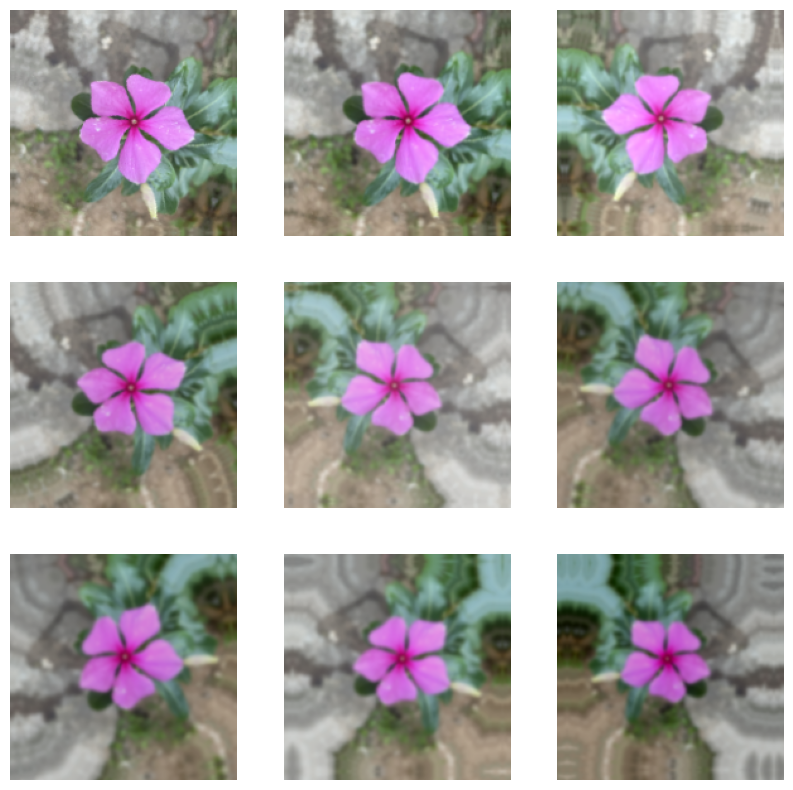

In [125]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [126]:
#Model Creation

In [130]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    
    Conv2D(16, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),
    
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(20, activation='softmax')  # Softmax for multi-class classification and num_classes = 20(flower types)
])


In [131]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [132]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_28 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 90, 90, 32)      

In [133]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Define Learning Rate Scheduler
def scheduler(epoch, lr):
    # Example: Reduce learning rate by a factor of 0.1 after every 10 epochs
    if epoch % 10 == 0 and epoch > 0:
        lr = lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with EarlyStopping and Learning Rate Scheduler
history = model.fit(
    train_ds,
    epochs=25,  # You can keep this as is, the training will stop earlier if no improvements
    validation_data=val_ds,
    callbacks=[early_stopping, lr_scheduler]  # Add both callbacks here
)


Epoch 1/25
407/407 [==============================] - 205s 499ms/step - loss: 1.3561 - accuracy: 0.5779 - val_loss: 2.0720 - val_accuracy: 0.3535 - lr: 0.0010
Epoch 2/25
407/407 [==============================] - 214s 527ms/step - loss: 0.8262 - accuracy: 0.7365 - val_loss: 0.7875 - val_accuracy: 0.7551 - lr: 0.0010
Epoch 3/25
407/407 [==============================] - 206s 506ms/step - loss: 0.6475 - accuracy: 0.7935 - val_loss: 0.6991 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 4/25
407/407 [==============================] - 197s 483ms/step - loss: 0.5439 - accuracy: 0.8252 - val_loss: 0.5557 - val_accuracy: 0.8252 - lr: 0.0010
Epoch 5/25
407/407 [==============================] - 197s 485ms/step - loss: 0.4622 - accuracy: 0.8540 - val_loss: 0.4089 - val_accuracy: 0.8745 - lr: 0.0010
Epoch 6/25
407/407 [==============================] - 197s 484ms/step - loss: 0.4079 - accuracy: 0.8688 - val_loss: 0.9984 - val_accuracy: 0.7289 - lr: 0.0010
Epoch 7/25
407/407 [==========================

In [134]:
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]

final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_loss:.4f}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")

print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Final Training Accuracy: 0.1297
Final Training Accuracy: 0.9578
Final Validation Loss: 0.2030
Final Validation Accuracy: 0.9415


In [135]:
   def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [138]:
classify_images('Sample/1.jpg')


1/1 [==============================] - 0s 24ms/step


'The Image belongs to tulip with a score of 12.489158660173416'

In [139]:
model.save('Flower_Recognition_Model_v2.h5')